In [ ]:
# if you have google drive permission then use this 

from google.colab import drive
drive.mount('/gdrive')
!ln -s   /gdrive/MyDrive/colab/Credit_Card/data/ /content/data

Mounted at /gdrive


In [ ]:
# f1id = '1W0EL3w6qxHRa5ZFPYhYl87Piv7Y94ELG'
# f1id = '1SvJ_IiHr-ndJDG_sBf6NCn0lMKUxPIlf'
# f2id = '1mJv80_a17wXnXydZEPGXKFtnQRd5REsc'

# !pip3 install gdown
# import gdown
# url = 'https://drive.google.com/uc?id=%s'%(f1id)
# output = 'train.csv'
# gdown.download(url, output, quiet=False)
# url = 'https://drive.google.com/uc?id=%s'%(f2id)
# output = 'test.csv'
# gdown.download(url, output, quiet=False)

!pip3 install gdown
import gdown

f3id = '1-2618saTS6OzD17x3NCol7_0O7rYSg0L'
url = 'https://drive.google.com/uc?id=%s'%(f3id)
output = 'train.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-2618saTS6OzD17x3NCol7_0O7rYSg0L
To: /content/train.csv
1.07GB [00:06, 157MB/s]


'train.csv'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

In [ ]:
train = pd.read_csv('train.csv')
# test = pd.read_csv('test.csv')

In [ ]:
print("train.shape",train.shape)
# print("test.shape",test.shape)

train.shape (1141340, 229)


# 資料欄位

*   acqic - 收單行代碼
*   bacno - 歸戶帳號
*   cano - 卡號
*   conam - 交易金額(台幣)
*   contp - 交易類別(e.g. 一般交易/刷退...)
*   csmcu - 消費地幣別
*   ecfg - 網路交易註記
*   etymd - 交易型態(e.g. 實體交易/網路交易)
*   flbmk - Fallback交易註記(預先授權)
*   flg_3dsmk - 3DS交易驗證註記
*   hecfg - 支付型態
*   insfg - 分期交易註記
*   iterm - 分期期數
*   locdt - 授權日期
*   loctm - 授權時間(HHMMSS)
*   mcc - 特店類別
*   mchno - 特店名稱
*   ovrlt - 超額交易註記
*   scity - 消費地城市
*   stocn - 消費地國別
*   stscd - 狀態碼
*   stscd - 狀態碼
*  txkey - 交易序號(唯一值)
*  fraud_ind - 冒用交易註記(預測目標)

In [ ]:
train.head(5)

,txkey,conam,contp_0,contp_1,contp_2,contp_3,contp_4,contp_5,contp_6,csmcu_0,csmcu_1,csmcu_2,csmcu_3,csmcu_4,csmcu_5,csmcu_6,csmcu_7,csmcu_9,csmcu_10,csmcu_11,csmcu_12,csmcu_13,csmcu_14,csmcu_15,csmcu_16,csmcu_17,csmcu_18,csmcu_19,csmcu_20,csmcu_21,csmcu_22,csmcu_23,csmcu_24,csmcu_25,csmcu_26,csmcu_27,csmcu_28,csmcu_29,csmcu_30,csmcu_31,...,stocn_73,stocn_74,stocn_75,stocn_76,stocn_77,stocn_78,stocn_79,stocn_80,stocn_81,stocn_82,stocn_83,stocn_84,stocn_85,stocn_86,stocn_87,stocn_88,stocn_89,stocn_90,stocn_91,stocn_92,stocn_93,stocn_94,stocn_95,stocn_96,stocn_97,stocn_98,stocn_99,stocn_100,stocn_101,stocn_102,stocn_104,stocn_105,stocn_106,stocn_107,stscd_0,stscd_1,stscd_2,stscd_3,stscd_4,fraud_ind_0
0,516056,-0.349849,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,483434,-0.349849,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1407164,0.897173,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1051004,0.146318,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1622153,2.859350,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# test.head(5)

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
0,0,134508,45725,465.62,5,0,N,2,N,N,0,0,N,0,9,105114.0,451,0,N,5817,102,0,4376
1,0,78377,2295,465.62,5,0,N,2,N,N,0,0,N,0,6,104918.0,451,0,N,5817,102,0,2943
2,0,151054,197751,465.62,5,0,N,2,N,N,0,0,N,0,7,104917.0,451,0,N,5817,102,0,3387
3,6716,150887,4541,930.31,5,62,N,4,N,N,0,5,N,0,8,142028.0,329,37560,N,5820,102,0,1765957
4,6882,110356,133430,0.00,5,0,N,0,N,N,0,0,N,0,9,143657.0,459,2461,N,0,102,0,611269


### **Training Set Correlation Heatmap**

In [ ]:
# print(type(train.keys()))
keys = []
for key in train.keys():
  keys.append(key)
  # print(key)
print(len(keys))

# Y - target
fraud = [keys[228]]

# 連續型
txkey = [keys[0]]
conam = [keys[1]]

# 類別型
contp = keys[2:9]
csmcu = keys[9:81]
ecfg = keys[81:83]
etymd = keys[83:94]
flbmk = keys[94:96]
flg_3dsmk = keys[96:98]
hcefg = keys[98:107]
insfg = keys[107:109]
iterm = keys[109:118]
ovrlt = keys[118:120]
stocn = keys[120:223]
stscd = keys[223:228]


229


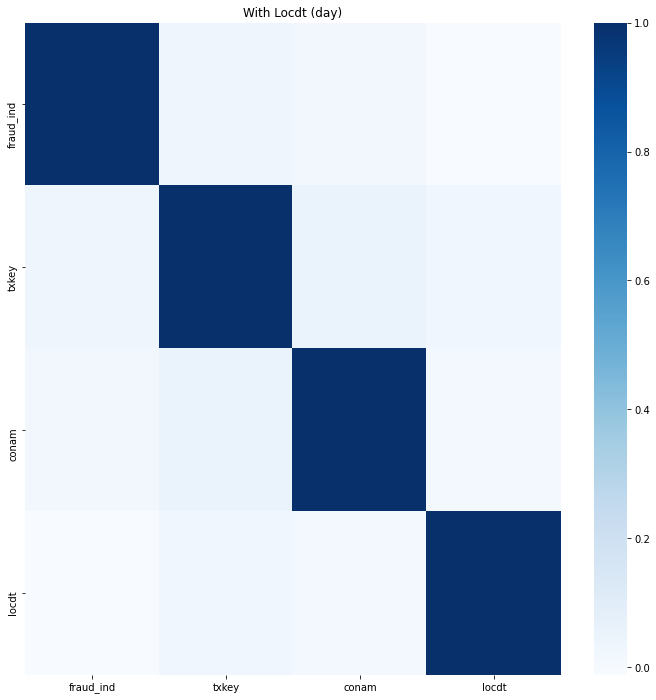

In [ ]:
data = train[ fraud+txkey+conam+stscd ]

fig=plt.figure(figsize= (12, 12))
fig = plt.title('With [ blank ] ')
sns.heatmap(data.corr(), cmap='Blues')

plt.show()

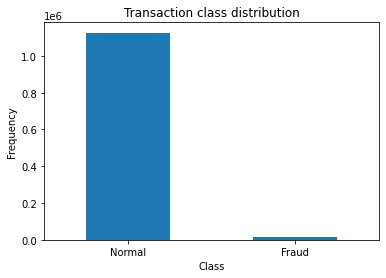

In [ ]:
LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(train['fraud_ind'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [ ]:
frauds = train[train.fraud_ind == 1]
normal = train[train.fraud_ind == 0]
# frauds = test[train.fraud_ind == 1]
# normal = test[train.fraud_ind == 0]

print(frauds.shape)
print(normal.shape)

(15283, 23)
(1126057, 23)


## **盜刷案件的金額通常較小**

<Figure size 18000x7200 with 0 Axes>

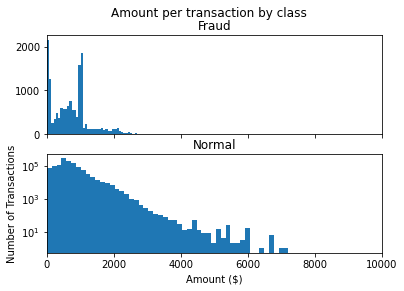

In [ ]:
fig=plt.figure(figsize= (250,100)) 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.conam, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.conam, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 10000))
plt.yscale('log')
plt.show();

In [ ]:
print(frauds['conam'].describe())

count    15283.000000
mean       713.072810
std        564.219474
min          0.000000
25%        223.110000
50%        696.350000
75%       1016.340000
max       3353.250000
Name: conam, dtype: float64


## **盜刷案件的時間分布：平均**

<Figure size 18000x7200 with 0 Axes>

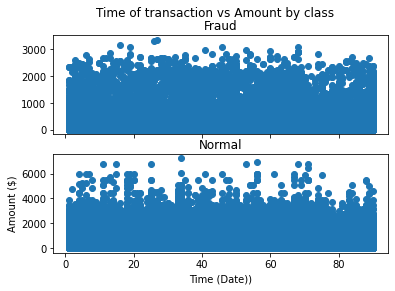

In [ ]:
fig=plt.figure(figsize= (250,100)) 
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.locdt, frauds.conam)
ax1.set_title('Fraud')

ax2.scatter(normal.locdt, normal.conam)
ax2.set_title('Normal')

plt.xlabel('Time (Date))')
plt.ylabel('Amount ($)')
plt.show()

In [ ]:
# 資料修改前
train.head(5)

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
0,6881,113261,38038,513.80,5,0,N,0,N,N,0,5,N,0,33,172652.0,457,59333,N,0,102,0,516056
1,6881,15408,188328,513.80,5,0,N,0,N,N,0,5,N,0,6,152458.0,457,59333,N,0,102,0,483434
2,6716,157159,29967,1016.11,5,62,N,5,N,N,0,5,N,0,5,172946.0,247,50436,N,3281,102,0,1407164
3,5975,105985,81305,713.66,5,62,N,4,N,N,0,5,N,0,6,182129.0,263,93775,N,5817,102,0,1051004
4,6411,94435,49219,1806.49,3,62,N,4,N,N,0,5,N,0,6,172624.0,339,0,N,5865,102,0,1622153


In [ ]:
## 新增小時、分、秒欄位
train['loctm_hh'] = train['loctm'].apply(lambda x: math.floor(x/10000))
train['loctm_mm'] = train['loctm'].apply(lambda x: math.floor(x/100)-math.floor(x/10000)*100)
train['loctm_ss'] = train['loctm'].apply(lambda x: math.floor(x)-math.floor(x/100)*100)

test['loctm_hh'] = test['loctm'].apply(lambda x: math.floor(x/10000))
test['loctm_mm'] = test['loctm'].apply(lambda x: math.floor(x/100)-math.floor(x/10000)*100)
test['loctm_ss'] = test['loctm'].apply(lambda x: math.floor(x)-math.floor(x/100)*100)

# 把'Y'變成1，'N'變成0
train['ecfg'] = (train['ecfg']=='Y').astype(int)
train['flbmk'] = (train['flbmk']=='Y').astype(int)
train['flg_3dsmk'] = (train['flg_3dsmk']=='Y').astype(int)
train['insfg'] = (train['insfg']=='Y').astype(int)
train['ovrlt'] = (train['ovrlt']=='Y').astype(int)
train['fraud_ind'] = (train['fraud_ind']=='Y').astype(int)

test['ecfg'] = (test['ecfg']=='Y').astype(int)
test['flbmk'] = (test['flbmk']=='Y').astype(int)
test['flg_3dsmk'] = (test['flg_3dsmk']=='Y').astype(int)
test['insfg'] = (test['insfg']=='Y').astype(int)
test['ovrlt'] = (test['ovrlt']=='Y').astype(int)
test['fraud_ind'] = (test['fraud_ind']=='Y').astype(int)

In [ ]:
train.head(5)

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,loctm_hh,loctm_mm,loctm_ss
0,6881,113261,38038,513.80,5,0,0,0,0,0,0,5,0,0,33,172652.0,457,59333,0,0,102,0,516056,17,26,52
1,6881,15408,188328,513.80,5,0,0,0,0,0,0,5,0,0,6,152458.0,457,59333,0,0,102,0,483434,15,24,58
2,6716,157159,29967,1016.11,5,62,0,5,0,0,0,5,0,0,5,172946.0,247,50436,0,3281,102,0,1407164,17,29,46
3,5975,105985,81305,713.66,5,62,0,4,0,0,0,5,0,0,6,182129.0,263,93775,0,5817,102,0,1051004,18,21,29
4,6411,94435,49219,1806.49,3,62,0,4,0,0,0,5,0,0,6,172624.0,339,0,0,5865,102,0,1622153,17,26,24


# **顧客分類**
前提假設：假定顧客皆為理性消費者，會根據信用卡的權益內容選定適合的信用卡進行消費
根據玉山銀行信用卡產品，主要分為以下三類：

* 聯名卡：針對聯名特店進行消費（ex: 家樂福聯名卡、南山人壽聯名卡、統一時代聯名卡等）
* 海外消費：針對海外交易進行消費（ex: 雙幣卡、only卡）
* 一般消費：Pi 拍錢包信用卡、UBear信用卡（針對數位通路.超商等消費加碼回饋）
---
分類基準：
* 是否為海外消費
* 是否為網購
* MCC消費種類數(商戶類別代碼Merchant Category Code是零售金融行業分配的4位數編碼，根據商戶類型（例如超市、酒店等）或商戶名稱（如3000為美聯航）。)

### **各種視覺化 (後面沒毛用)**

In [ ]:
# original data
f1id = '1W0EL3w6qxHRa5ZFPYhYl87Piv7Y94ELG'
f2id = '1mJv80_a17wXnXydZEPGXKFtnQRd5REsc'

!pip3 install gdown
import gdown
url = 'https://drive.google.com/uc?id=%s'%(f1id)
output = 'train.csv'
gdown.download(url, output, quiet=False)
url = 'https://drive.google.com/uc?id=%s'%(f2id)
output = 'test.csv'
gdown.download(url, output, quiet=False)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape

Downloading...
From: https://drive.google.com/uc?id=1W0EL3w6qxHRa5ZFPYhYl87Piv7Y94ELG
To: /content/train.csv
99.2MB [00:02, 40.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mJv80_a17wXnXydZEPGXKFtnQRd5REsc
To: /content/test.csv
33.1MB [00:00, 78.1MB/s]


(1141340, 23)

In [ ]:
train

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
0,6881,113261,38038,513.80,5,0,N,0,N,N,0,5,N,0,33,172652.0,457,59333,N,0,102,0,516056
1,6881,15408,188328,513.80,5,0,N,0,N,N,0,5,N,0,6,152458.0,457,59333,N,0,102,0,483434
2,6716,157159,29967,1016.11,5,62,N,5,N,N,0,5,N,0,5,172946.0,247,50436,N,3281,102,0,1407164
3,5975,105985,81305,713.66,5,62,N,4,N,N,0,5,N,0,6,182129.0,263,93775,N,5817,102,0,1051004
4,6411,94435,49219,1806.49,3,62,N,4,N,N,0,5,N,0,6,172624.0,339,0,N,5865,102,0,1622153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141335,6032,2510,54094,1.38,5,75,Y,2,NaN,NaN,0,6,N,0,30,231435.0,248,78297,N,5817,102,0,196080
1141336,1801,12832,137381,1138.04,5,75,Y,8,NaN,NaN,0,6,N,0,1,100009.0,201,198,N,1852,98,0,642025
1141337,6322,91008,15189,578.38,5,75,Y,8,NaN,NaN,0,6,N,0,4,191642.0,209,38222,N,5817,102,0,1478280
1141338,3226,145107,116252,435.32,5,75,Y,8,NaN,NaN,0,6,N,0,13,102338.0,192,90135,N,1458,102,0,661087


In [ ]:
test

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,fraud_ind,hcefg,insfg,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
0,0,134508,45725,465.62,5,0,N,2,N,N,0,0,N,0,9,105114.0,451,0,N,5817,102,0,4376
1,0,78377,2295,465.62,5,0,N,2,N,N,0,0,N,0,6,104918.0,451,0,N,5817,102,0,2943
2,0,151054,197751,465.62,5,0,N,2,N,N,0,0,N,0,7,104917.0,451,0,N,5817,102,0,3387
3,6716,150887,4541,930.31,5,62,N,4,N,N,0,5,N,0,8,142028.0,329,37560,N,5820,102,0,1765957
4,6882,110356,133430,0.00,5,0,N,0,N,N,0,0,N,0,9,143657.0,459,2461,N,0,102,0,611269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380442,5588,95249,112041,1.38,5,75,Y,8,NaN,NaN,0,6,N,0,17,194234.0,296,73998,N,3426,42,0,668463
380443,6215,85771,169553,609.21,5,75,Y,2,NaN,NaN,0,6,N,0,14,133907.0,289,54828,N,3460,46,0,1846986
380444,6231,139728,168027,574.36,5,75,N,5,NaN,NaN,0,6,N,0,28,155437.0,245,18405,N,5817,102,0,992751
380445,6032,45406,197460,1.38,5,75,Y,2,NaN,NaN,0,6,N,0,24,215218.0,373,79246,N,5817,102,0,338215


In [ ]:
frauds = train['fraud_ind']
cnt = 0
for val in frauds:
  if val == 1: cnt += 1
print(cnt)

frauds = test['fraud_ind']
cnt = 0
for val in frauds:
  if val == 1: cnt += 1
print(cnt)

15283
5072


##### **visuals start here**

In [ ]:
# plot all four from here
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

key = 'scity'  # plot which lable
start = 0
max_show = 10  # show at most categories


Text(0.5, 1.0, 'test (DO NOT USE) fraudulent cases by scity')

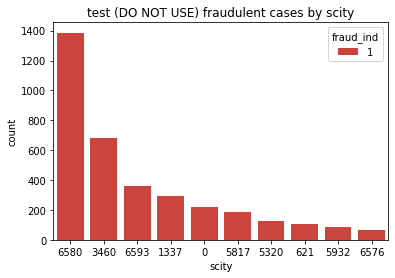

In [ ]:
x = sns.countplot(x=key, hue="fraud_ind", data=test[test.fraud_ind==1], palette="Reds_d",
              order=pd.value_counts(test[test.fraud_ind==1][key]).iloc[start:start+max_show].index)
x.set_title(f'test (DO NOT USE) fraudulent cases by {key}')

Text(0.5, 1.0, 'test (DO NOT USE) normal cases by scity')

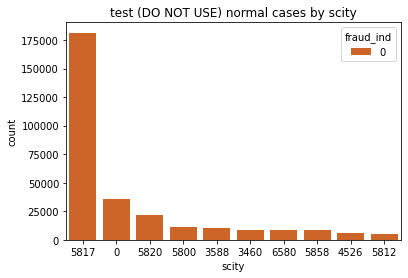

In [ ]:
x = sns.countplot(x=key, hue="fraud_ind", data=test[test.fraud_ind==0], palette="Oranges_d",
              order=pd.value_counts(test[test.fraud_ind==0][key]).iloc[start:start+max_show].index)
x.set_title(f'test (DO NOT USE) normal cases by {key}')

Text(0.5, 1.0, 'train fraudulent cases by scity')

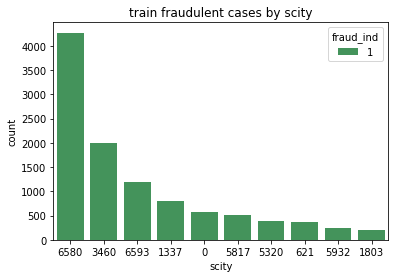

In [ ]:
x = sns.countplot(x=key, hue="fraud_ind", data=train[train.fraud_ind==1], palette="Greens_d",
              order=pd.value_counts(train[train.fraud_ind==1][key]).iloc[start:start+max_show].index)

# print(pd.value_counts(train[train.fraud_ind==1][key]).iloc[start:start+max_show].index)
x.set_title(f'train fraudulent cases by {key}')
## 102為國內消費

Text(0.5, 1.0, 'train normal cases by scity')

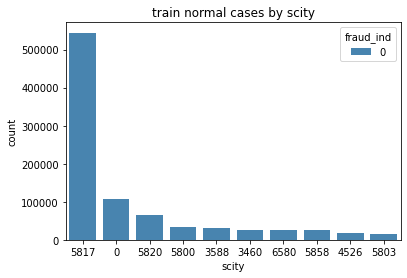

In [ ]:
x = sns.countplot(x=key, hue="fraud_ind", data=train[train.fraud_ind==0], palette="Blues_d",
              order=pd.value_counts(train[train.fraud_ind==0][key]).iloc[start:start+max_show].index)

x.set_title(f'train normal cases by {key}')

##### **end visuals**

In [ ]:
train["oversea_flag"] = train.stocn != 102

In [ ]:
# change to percentage 0 代表為國內
oversea_pct = train.loc[:,['cano','oversea_flag']][train.fraud_ind!=-1].groupby('cano').mean()
print(oversea_pct)

        oversea_flag
cano                
0                0.0
1                0.0
2                0.0
3                0.0
5                0.0
...              ...
213309           0.0
213317           0.0
213321           0.0
213329           1.0
213334           0.0

[124310 rows x 1 columns]


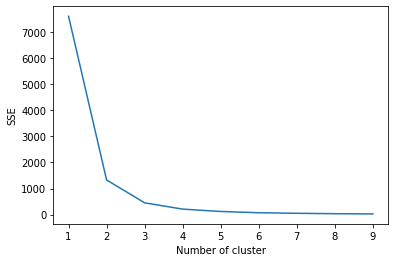

In [ ]:
# clustering by k-means with elbow method
from sklearn.cluster import KMeans

sse = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(oversea_pct)
#   oversea_pct["clusters"] = kmeans.labels_
#   print(oversea_pct["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### **是否網路消費**

In [ ]:
# k = 2 
# cano：卡號 / ecfg：網路交易註記
kmeans = KMeans(n_clusters=2, max_iter=1000).fit(oversea_pct)
oversea_pct["clusters"] = kmeans.labels_
oversea_pct.head(20)

,oversea_flag,clusters
cano,,
0,0.000000,1
1,0.000000,1
2,0.000000,1
3,0.000000,1
5,0.000000,1
7,0.000000,1
8,0.181818,1
9,0.000000,1
10,0.000000,1


In [ ]:
# change to percentage
# cano：卡號 / ecfg：網路交易註記
ecfg_pct = train.loc[:,['cano','ecfg']][train.fraud_ind!=-1].groupby('cano').mean()
print(ecfg_pct)

            ecfg
cano            
0       0.000000
1       0.000000
2       0.074074
3       0.000000
5       0.111111
...          ...
213309  0.000000
213317  0.000000
213321  0.000000
213329  1.000000
213334  0.000000

[124310 rows x 1 columns]


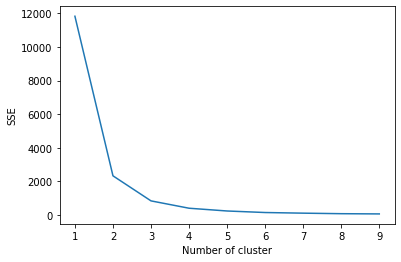

In [ ]:
# clustering by k-means with elbow method
from sklearn.cluster import KMeans

sse = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(ecfg_pct)
#   oversea_pct["clusters"] = kmeans.labels_
#   print(oversea_pct["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
# k = 2 
kmeans = KMeans(n_clusters=2, max_iter=1000).fit(ecfg_pct)
ecfg_pct["clusters"] = kmeans.labels_
# ecfg_pct.head(20)

### **MCC**

#### MCC消費種類分群 [(連結)](https://zh.wikipedia.org/wiki/商户类别代码)

---
由於一個商戶類別是由好幾種MCC CODE組成  
假定同一種商戶類別，底下各自的MCC CODE資料有相似的敘述統計量


In [ ]:
# conam - 交易金額(台幣)
mcc_code = train.loc[:,['mcc', 'conam']].groupby(['mcc']).describe() 
mcc_code

conam                           ...                            
       count         mean         std  ...      50%       75%      max
mcc                                    ...                            
0        3.0  1923.273333  330.105003  ...  1767.51  2034.975  2302.44
1        1.0  1063.150000         NaN  ...  1063.15  1063.150  1063.15
2       54.0   989.153889  338.899635  ...   966.45  1193.295  2168.49
3       79.0   565.248354  272.055275  ...   490.68   744.255  1342.53
4        1.0   731.820000         NaN  ...   731.82   731.820   731.82
..       ...          ...         ...  ...      ...       ...      ...
455      2.0     0.000000    0.000000  ...     0.00     0.000     0.00
456     13.0   592.389231  139.878903  ...   602.53   680.570   860.07
457  77429.0   521.192606   34.612743  ...   513.80   513.800   683.25
458    694.0     0.000000    0.000000  ...     0.00     0.000     0.00
459   3625.0     0.000000    0.000000  ...     0.00     0.000     0.00

[418 rows x 8 columns]

In [ ]:
mcc_code.columns

MultiIndex([('conam', 'count'),
            ('conam',  'mean'),
            ('conam',   'std'),
            ('conam',   'min'),
            ('conam',   '25%'),
            ('conam',   '50%'),
            ('conam',   '75%'),
            ('conam',   'max')],
           )

In [ ]:
mcc_code.columns = mcc_code.columns.droplevel()

In [ ]:
mcc_code.fillna(0, inplace=True)

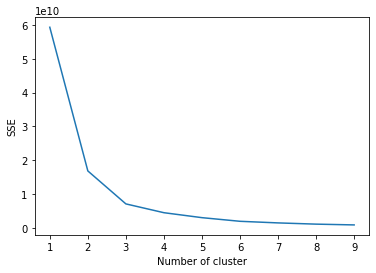

In [ ]:
# clustering by k-means with elbow method
from sklearn.cluster import KMeans

sse = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(mcc_code)
#   oversea_pct["clusters"] = kmeans.labels_
#   print(oversea_pct["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

#### 各卡MCC消費占比

In [ ]:
# count mcc
mcc_txn_cnt = train.loc[:,['cano', 'mcc', 'conam']][train.fraud_ind!=-1].groupby(['cano','mcc']).count()
mcc_cnt = train.loc[:,['cano','mcc', 'conam']][train.fraud_ind!=-1].groupby(['cano','mcc']).count().groupby(['cano']).count()

In [ ]:
mcc_txn_cnt.groupby(['cano']).mean().head(5)

,conam
cano,
0,2.000000
1,1.000000
2,6.750000
3,1.000000
5,2.571429


In [ ]:
mcc_pct = mcc_txn_cnt.groupby(['cano']).apply(lambda x:100 * x / float(x.sum()))

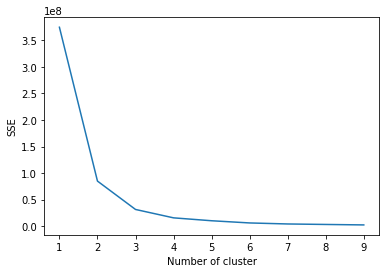

In [ ]:
# clustering by k-means with elbow method
from sklearn.cluster import KMeans

sse = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(mcc_pct)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
##k = 3 
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(mcc_pct)
mcc_pct["clusters"] = kmeans.labels_
mcc_pct

conam  clusters
cano   mcc                 
0      228   12.5         1
       251   62.5         2
       255   12.5         1
       286   12.5         1
1      286   50.0         2
...           ...       ...
213309 286  100.0         0
213317 247  100.0         0
213321 251  100.0         0
213329 408  100.0         0
213334 251  100.0         0

[469422 rows x 2 columns]

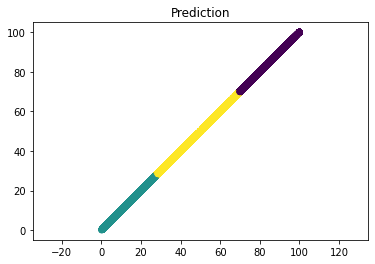

In [ ]:
#results visualization
plt.figure()
plt.scatter(mcc_pct['conam'], mcc_pct['conam'], c = mcc_pct['clusters']) # = 0,1,2
plt.axis('equal')
plt.title('Prediction')
plt.show()

In [ ]:
mcc_pct.groupby(['clusters']).describe()

conam                        ...                               
             count       mean        std  ...         50%    75%         max
clusters                                  ...                               
0          50307.0  95.142148   9.147536  ...  100.000000  100.0  100.000000
1         326461.0  10.990851   6.853531  ...    9.090909   16.0   27.380952
2          92654.0  43.782242  11.337700  ...   42.857143   50.0   69.444444

[3 rows x 8 columns]

#### 各卡MCC消費類型分群

In [ ]:
# cano:卡號 / 
mcc_pct_sum = mcc_pct.groupby(['cano','clusters']).sum()

In [ ]:
mcc_pct_sum['rank'] = mcc_pct.groupby(['cano','clusters']).sum().groupby(['cano']).rank(ascending=False, method='max')

In [ ]:
mcc_pct_sum[mcc_pct_sum['rank']==1].head(20)

,,conam,rank
cano,clusters,,
0,2,62.500000,1.0
1,2,100.000000,1.0
2,0,85.185185,1.0
3,0,100.000000,1.0
5,1,66.666667,1.0
7,1,100.000000,1.0
8,1,100.000000,1.0
9,0,90.000000,1.0
10,1,100.000000,1.0
